# Машинное обучение, DS-поток
## Задание ML.7K


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.


**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

**Баллы за задание:**

* Задача 2 &mdash; 90 баллов + бонусные баллы + медальки + гуси.


In [72]:
# Bot check

# HW_ID: ds_ml7k
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [32]:
import copy
import numpy as np
import pandas as pd

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, DMatrix

from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from catboost.datasets import titanic

import lightgbm
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedShuffleSplit, GroupShuffleSplit, ShuffleSplit
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor

from xgboost import plot_tree as plot_xgb_tree
from lightgbm import plot_tree as plot_lgbm_tree
from sklearn.tree import plot_tree as plot_sklearn_tree

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

---

### Задача 2

Рассмотрим одну из уже классических задач машинного обучения — предсказание кредитного рейтинга клиентов кредитной организации. В данной задаче вам нужно провести анализ данных, построить классификатор клиентов и отправить свои предсказания в Kaggle-соревнование.

Кредитный скоринг — система оценки кредитоспособности (кредитных рисков) потенциальных и действующих клиентов, в основу которой вкладываются статистические данные. Кредитный скоринг широко используется как крупными банками, микрофинансовыми организациями, так и в потребительском (магазинном) экспресс-кредитовании на небольшие суммы. Также возможно его использование в бизнесе сотовых операторов, страховых компаний и т. д. Скоринг заключается в присвоении баллов по заполнению некой анкеты, разработанной оценщиками кредитных рисков андеррайтерами. По результатам набранных баллов системой автоматически принимается решение об одобрении или отказе в выдаче кредита.

Описание данных:
* `client_id`: уникальный идентификатор клиента;
* `month`: месяц сбора информации;
* `age`: возраст клиента;
* `occupation`: вид деятельность;
* `annual_income`: годовой доход;
* `monthly_salary`: зарплата за текущий месяц;
* `number_bank_accounts`: количество банковских счетов у данного клиента;
* `number_credit_cards`: количество кредитных карт у данного клиента;
* `interest_rate`: процентная ставка по кредитной карте;
* `number_loan`: количество кредитов, взятых в банке;
* `delay_from_due_date`: среднее количество дней задержки выплат по кредиту;
* `number_delayed_payment`: количество платежей по кредиту, которые были выполнены с задержкой;
* `number_credit_inquiries`: количество запросов по кредиту;
* `unpaid_debt`: сумма долга;
* `credit_utilization_ratio`: коэффициент использования кредитных карт;
* `credit_history_age`: размер кредитной истории;
* `min_amount_payment`: была ли произведенная выплата минимально возможной;
* `monthy_amount_invested`: сумма инвестиций за месяц;
* `client_behaviour`: платежное поведение клиента;
* `monthly_balance`: баланс по итогу месяца;
* `credit_rating`: кредитный рейтинг — это **целевой признак**.

Ссылка: https://www.kaggle.com/competitions/ds-2024-autumn-37/

**Правила**

* В Kaggle в данное тренировочное соревнование можно отправлять не более 7 решений в день (8-ю система не позволит).
* Решения индивидуальные.
* Качество считается по метрике Accuracy.
* До окончания соревнования доступны значения качества, посчитанные только на случайных 30% тестовых данных. Значения отображаются в Public Leaderboard.
* После окончания соревнования становится доступным Private Leaderboard, в котором значения качества посчитанны на оставшихся 70% объектов.
* Для включения в Private Leaderboard можно выбрать две посылки.
* В Leaderboard должны отображаться ваши **реальные имя и фамилия**. В противном случае решение может быть не зачтено.
* Все файлы, которые вы отправляете в соревнование, видны организаторам соревнования. Файлы должны иметь понятное имя, при отправке файла в систему необходимо написать краткое описание решения. **Это будет проверяться.**
* В решении, отправляемом боту, должно быть отображено, результаты каких моделей вы отправляете в соревнование.
* Не забывайте сделать пояснения к своему решению. **Решение может быть не зачтено, если в нем недостаточно пояснений**, даже если удалось попасть в топ-3.
* Пользоваться можно любыми пройденными в наших курсах моделями.
* Нельзя пользоваться любыми методами и моделями, которые мы не проходили, и которых не было в ранее в иных курсах, которые обязательны для всех.
* Код студентов, занявших первые 3 места, будет запускаться. Также выборочно может запускаться код и остальных студентов.

**Советы**

* Чтобы получить действительно хороший результат подбора гиперпараметров мало, попробуйте ввести новые признаки для улучшения качества решения.
* Некоторые инсайты по тому, какие признаки могут улучшить качество, можно получить если провести разведывательный анализ данных (EDA). Например, может иметь смысл изучить датасет на предмет наличия выбросов, исследовать пространственное и временное распределение отклика. 
* Изучите различные методы, предложенные на занятиях.
* Сохраняйте код и результаты каждой модели в отдельных файлах. Добавляйте к ним понятные описания, которые помогут вам при необходимости продолжить использовать решение.

**Сроки сдачи**
 
* **Дедлайн в Kaggle** совпадает с дедлайном по заданию (25.10 16:00). Дедлайн строгий, Kaggle не позволит сдать даже на секунду позже.
* Также **до дедлайна необходимо сдать в бот** существующий вариант решения, возможно, без пояснений.
* **До конца следующих суток  (26.10 23:59)** необходимо дооформить решение, соответствующее наилучшему варианту по Private Leaderboard и сдать в бот по отдельной кнопке. **Решение может быть не зачтено, если в нем недостаточно пояснений**, даже если удалось попасть в топ-3.
* В случае, если вы до основного дедлайна сдаете оформленное решение, его нужно сдать по двум кнопкам сразу &mdash; соответствующей основной сдаче, и отдельной для оформленного решения.

**Баллы**

* **Выдаются только при соблюдении всех правил** и суммируются.
* 15 баллов — ваше решение лучше `sample_submission.csv` на Public Leaderboard.
* 15 баллов — ваше решение дает качество не менее 65% на Public Leaderboard.
* по 15 баллов — за каждый следующий преодоленный порог на Private Leaderboard, пороги: 66%, 66.3%, 66.6%, 67%.
* 30 баллов за попадание в топ-3 на Private Leaderboard и **шоколадная медаль** за соответствующее место.
* **Шоколадная медаль** попадание в топ-10 на Private Leaderboard.
* **Мягкий гусь**
    * за топ-1 на Private Leaderboard
    * за наиболее хорошо оформленное решение
    * за самую оригинальную идею (которая привела к улучшению).

Для начала загрузим данные:

In [33]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train

,client_id,month,age,occupation,annual_income,monthly_salary,number_bank_accounts,number_credit_cards,interest_rate,number_loan,...,number_delayed_payment,number_credit_inquiries,unpaid_debt,credit_utilization_ratio,credit_history_age,min_amount_payment,monthy_amount_invested,client_behaviour,monthly_balance,credit_rating
0,5e261a2ce0,Февраль,NaN,NaN,34811.50,2977.666667,2,4,6.0,1.0,...,4.0,2.0,605.03,24.464031,26 г. 7 м.,No,104.291825,"Малые траты, малые платежи",463.220627,Обычный
1,5e261a2ce0,Март,28.0,Учитель,34231.28,2991.866667,2,4,6.0,1.0,...,1.0,2.0,605.03,38.550848,26 г. 8 м.,No,40.391238,"Большие траты, большие платежи",478.941214,Хороший
2,5e261a2ce0,Апрель,28.0,Учитель,NaN,2979.906667,2,1385,6.0,1.0,...,NaN,2.0,605.03,33.224951,26 г. 9 м.,No,58.515976,"Большие траты, большие платежи",464.256476,Обычный
3,5e261a2ce0,Май,28.0,Учитель,34376.73,NaN,2,4,6.0,1.0,...,NaN,2.0,605.03,39.182656,26 г. 10 м.,No,99.306228,"Малые траты, средние платежи",457.656224,Хороший
4,5e261a2ce0,Июнь,28.0,Учитель,34415.88,2958.436667,2,4,6.0,1.0,...,1.0,2.0,605.03,34.977895,26 г. 11 м.,No,130.115420,"Малые траты, малые платежи",443.497032,Хороший
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,273554f220,Май,45.0,Медиаменеджер,15962.71,1510.639167,1,1,5.0,4.0,...,NaN,8.0,897.16,36.132095,21 г. 4 м.,No,199.988581,"Малые траты, малые платежи",197.400775,Хороший
63996,273554f220,Июнь,NaN,Медиаменеджер,16518.23,1504.069167,1,1,5.0,4.0,...,0.0,8.0,897.16,37.788217,21 г. 5 м.,No,64.549748,"Малые траты, большие платежи",310.219608,Плохой
63997,273554f220,Июль,45.0,Медиаменеджер,16081.07,1495.929167,1,1,5.0,4.0,...,NaN,8.0,897.16,24.972853,21 г. 6 м.,No,NaN,"Малые траты, малые платежи",224.671539,Хороший
63998,273554f220,Август,45.0,Медиаменеджер,NaN,1455.459167,1,1,5.0,4.0,...,NaN,8.0,897.16,36.166925,21 г. 7 м.,No,NaN,"Малые траты, малые платежи",339.924834,Хороший


Сразу видим и кучу пропусков в данных, и дупликаты по `client_id`, и гору категориальных признаков. Отсюда следует что лучше всего будет использовать модель `CatBoost`, поскольку он умеет работать с категориальными признаками лучше остальных. Дропать `client_id` как оказалось нельзя, надо использовать его для разбиения на группы, поскольку иначе в тренировочную и в валидационную выборку будут утекать очень похожие данные и точность на валидации будет сильно завышена. Первым делом переведем `credit_history_age` в месяцы

In [34]:
def convert_to_months(age_str):
    '''Переводит возраст кредитной истории в месяцы'''
    if pd.isna(age_str):
        return 0
    years, months = 0, 0
    parts = age_str.split()
    for i in range(len(parts)):
        if 'г.' in parts[i]:
            years = int(parts[i-1])
        elif 'м.' in parts[i]:
            months = int(parts[i-1])
    return years * 12 + months

train['credit_history_age'] = train['credit_history_age'].apply(convert_to_months)
test['credit_history_age'] = test['credit_history_age'].apply(convert_to_months)
train

,client_id,month,age,occupation,annual_income,monthly_salary,number_bank_accounts,number_credit_cards,interest_rate,number_loan,...,number_delayed_payment,number_credit_inquiries,unpaid_debt,credit_utilization_ratio,credit_history_age,min_amount_payment,monthy_amount_invested,client_behaviour,monthly_balance,credit_rating
0,5e261a2ce0,Февраль,NaN,NaN,34811.50,2977.666667,2,4,6.0,1.0,...,4.0,2.0,605.03,24.464031,319,No,104.291825,"Малые траты, малые платежи",463.220627,Обычный
1,5e261a2ce0,Март,28.0,Учитель,34231.28,2991.866667,2,4,6.0,1.0,...,1.0,2.0,605.03,38.550848,320,No,40.391238,"Большие траты, большие платежи",478.941214,Хороший
2,5e261a2ce0,Апрель,28.0,Учитель,NaN,2979.906667,2,1385,6.0,1.0,...,NaN,2.0,605.03,33.224951,321,No,58.515976,"Большие траты, большие платежи",464.256476,Обычный
3,5e261a2ce0,Май,28.0,Учитель,34376.73,NaN,2,4,6.0,1.0,...,NaN,2.0,605.03,39.182656,322,No,99.306228,"Малые траты, средние платежи",457.656224,Хороший
4,5e261a2ce0,Июнь,28.0,Учитель,34415.88,2958.436667,2,4,6.0,1.0,...,1.0,2.0,605.03,34.977895,323,No,130.115420,"Малые траты, малые платежи",443.497032,Хороший
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,273554f220,Май,45.0,Медиаменеджер,15962.71,1510.639167,1,1,5.0,4.0,...,NaN,8.0,897.16,36.132095,256,No,199.988581,"Малые траты, малые платежи",197.400775,Хороший
63996,273554f220,Июнь,NaN,Медиаменеджер,16518.23,1504.069167,1,1,5.0,4.0,...,0.0,8.0,897.16,37.788217,257,No,64.549748,"Малые траты, большие платежи",310.219608,Плохой
63997,273554f220,Июль,45.0,Медиаменеджер,16081.07,1495.929167,1,1,5.0,4.0,...,NaN,8.0,897.16,24.972853,258,No,NaN,"Малые траты, малые платежи",224.671539,Хороший
63998,273554f220,Август,45.0,Медиаменеджер,NaN,1455.459167,1,1,5.0,4.0,...,NaN,8.0,897.16,36.166925,259,No,NaN,"Малые траты, малые платежи",339.924834,Хороший


Зададим, какие признаки категориальные, а какие вещественные:

In [35]:
target = 'credit_rating'
cat_features = ['occupation', 'month', 'min_amount_payment', 'client_behaviour']
real_features = ['age', 'annual_income', 'monthly_salary', 'number_bank_accounts', 'credit_history_age','number_credit_cards', 'interest_rate', 'number_loan', 'delay_from_due_date', 'number_delayed_payment', 'number_credit_inquiries', 'unpaid_debt', 'credit_utilization_ratio', 'monthy_amount_invested', 'monthly_balance']

Посмотрим, есть ли явные выбросы в данных по вещественным признакам:

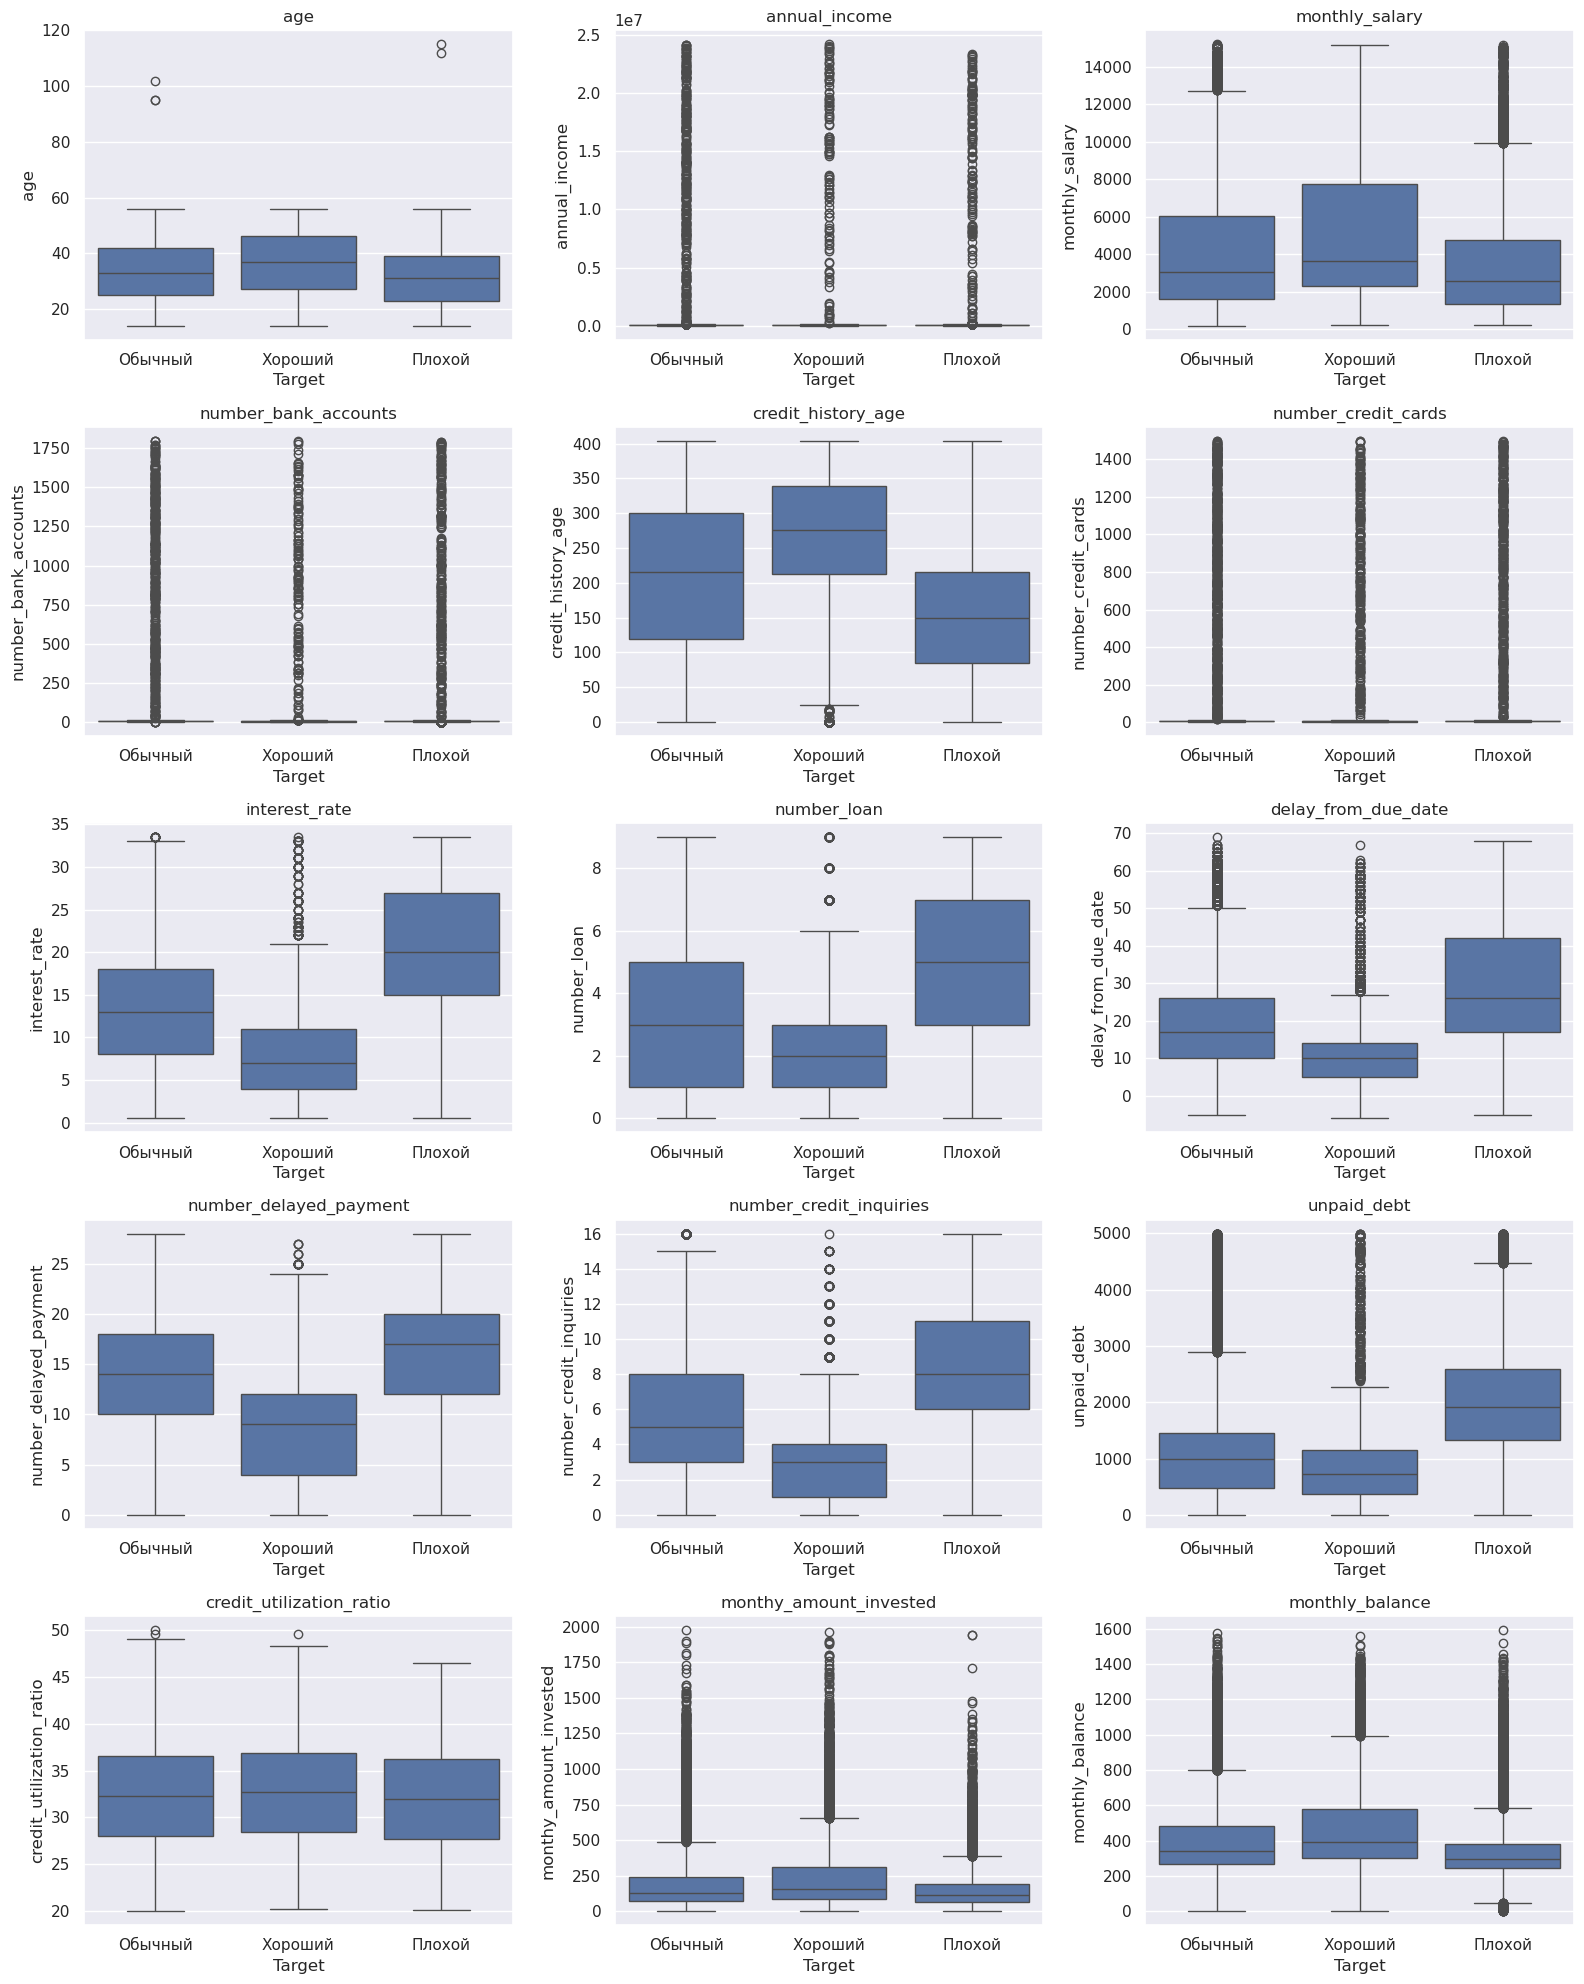

In [36]:
# Установка стиля графиков
sns.set(style="darkgrid")
plt.figure(figsize=(16, 20))
for i, param in zip(range(1, 16), real_features):
    ax = plt.subplot(5, 3, i)
    sns.boxplot(x='credit_rating', y=param, data=train, ax=ax)
    ax.set_title(f'{param}')
    ax.set_xlabel('Target')
    ax.set_ylabel(param)
    plt.tight_layout()

plt.show()

Попробуем прологарифмировать признаки и повторить исследование:

/tmp/ipykernel_9371/1503710816.py:3: RuntimeWarning: divide by zero encountered in log
  return np.log(num + 1)
/tmp/ipykernel_9371/1503710816.py:3: RuntimeWarning: invalid value encountered in log
  return np.log(num + 1)


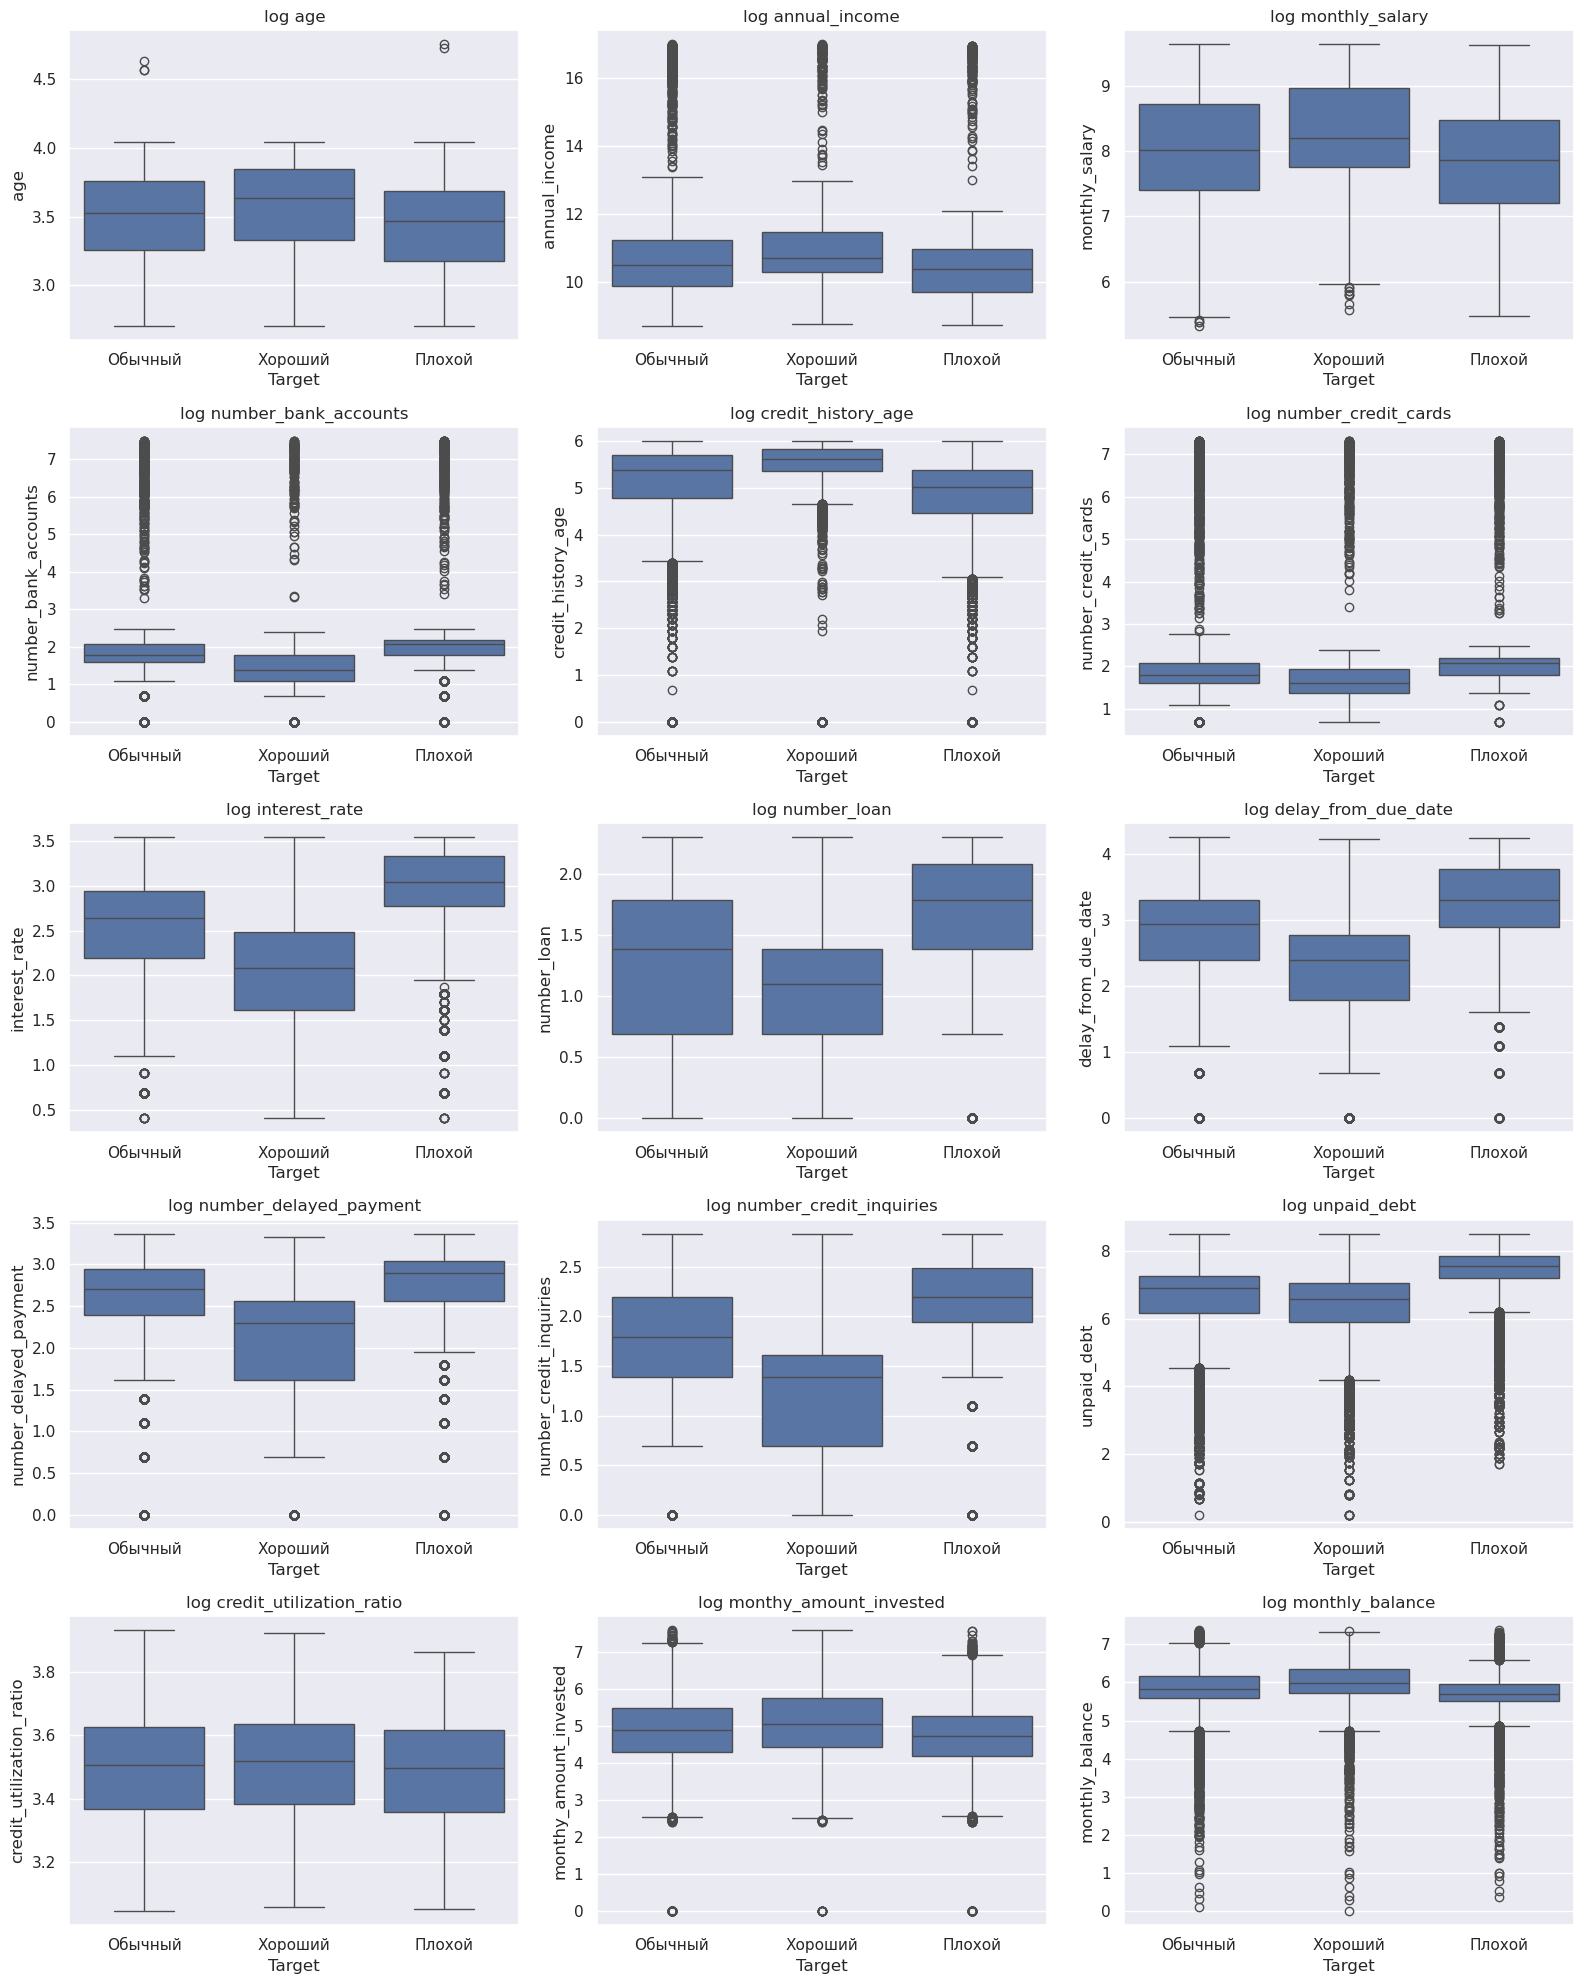

In [37]:
def log_num(num):
    if not pd.isna(num):
        return np.log(num + 1)

train_copy = train.copy()
for feature in real_features:
    train_copy[feature] = train_copy[feature].apply(log_num)
plt.figure(figsize=(16, 20))
for i, param in zip(range(1, 16), real_features):
    ax = plt.subplot(5, 3, i)
    sns.boxplot(x='credit_rating', y=param, data=train_copy, ax=ax)
    ax.set_title(f'log {param}')
    ax.set_xlabel('Target')
    ax.set_ylabel(param)
    plt.tight_layout()

plt.show()

Сделаем отдельные выводы по каждому признаку:
* `age`:                      свечи разные, выбросов нет, `Хороший` признак
* `annual_income`:            свечи микроскопические, тонна выбросов, `Плохой` признак
* `monthly_salary`:           свечи разные, немного выбросов, `Средний` признак
* `number_bank_accounts`:     свечи микроскопические, тонна выбросов, `Плохой` признак,
* `number_credit_cards`:      свечи микроскопические, тонна выбросов, `Плохой` признак
* `interest_rate`:            свечи очень разные, выбросов минимально, `Хороший` признак
* `number_loan`:              свечи очень разные, выбросов минимально, `Хороший` признак
* `delay_from_due_date`:      очень разные свечи, многовато выбросов, `Средний` признак
* `number_delayed_payment`:   свечи очень разные, выбросов минимально, `Хороший` признак
* `number_credit_inquiries`:  свечи очень разные, выбросов минимально, `Хороший` признак
* `unpaid_debt`:              очень разные свечи, но многовато выбросов, `Средний` признак
* `credit_utilization_ratio`: свечи очень разные, выбросов минимально, `Хороший` признак
* `credit_history_age`:       свечи очень разные, выбросов минимально, `Хороший` признак
* `monthy_amount_invested`:   очень разные свечи, но многовато выбросов, `Средний` признак
* `monthly_balance`:          очень разные свечи, но многовато выбросов, `Средний` признак

Посмотрим также на количество пропущенных значений по каждому признаку:

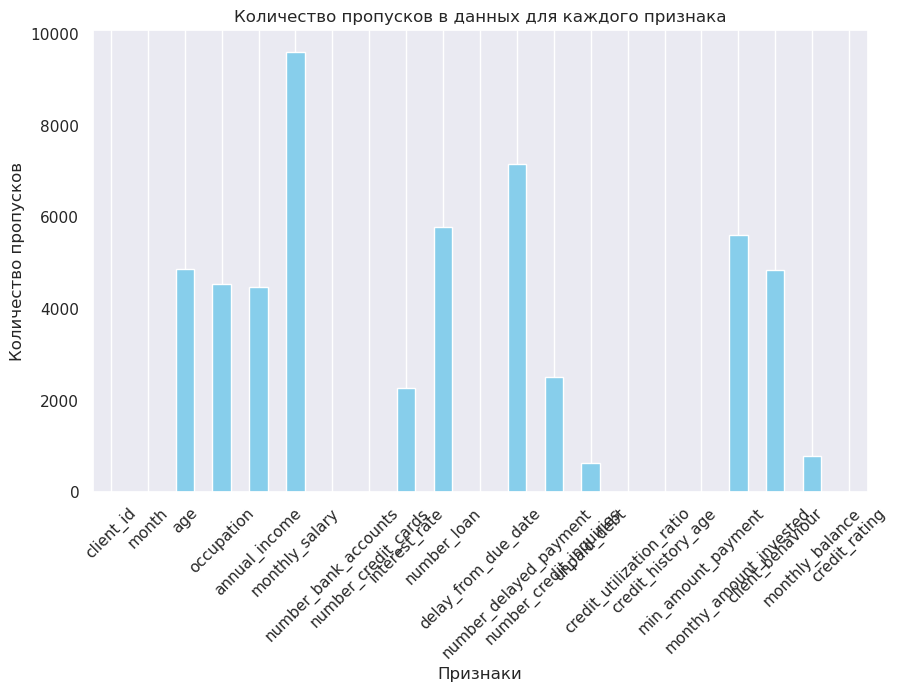

In [38]:
missing_counts = train.isnull().sum()

# Строим гистограмму
plt.figure(figsize=(10, 6))
missing_counts.plot(kind='bar', color='skyblue')
plt.title('Количество пропусков в данных для каждого признака')
plt.xlabel('Признаки')
plt.ylabel('Количество пропусков')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

И на матрицу ковариаций между признаками:

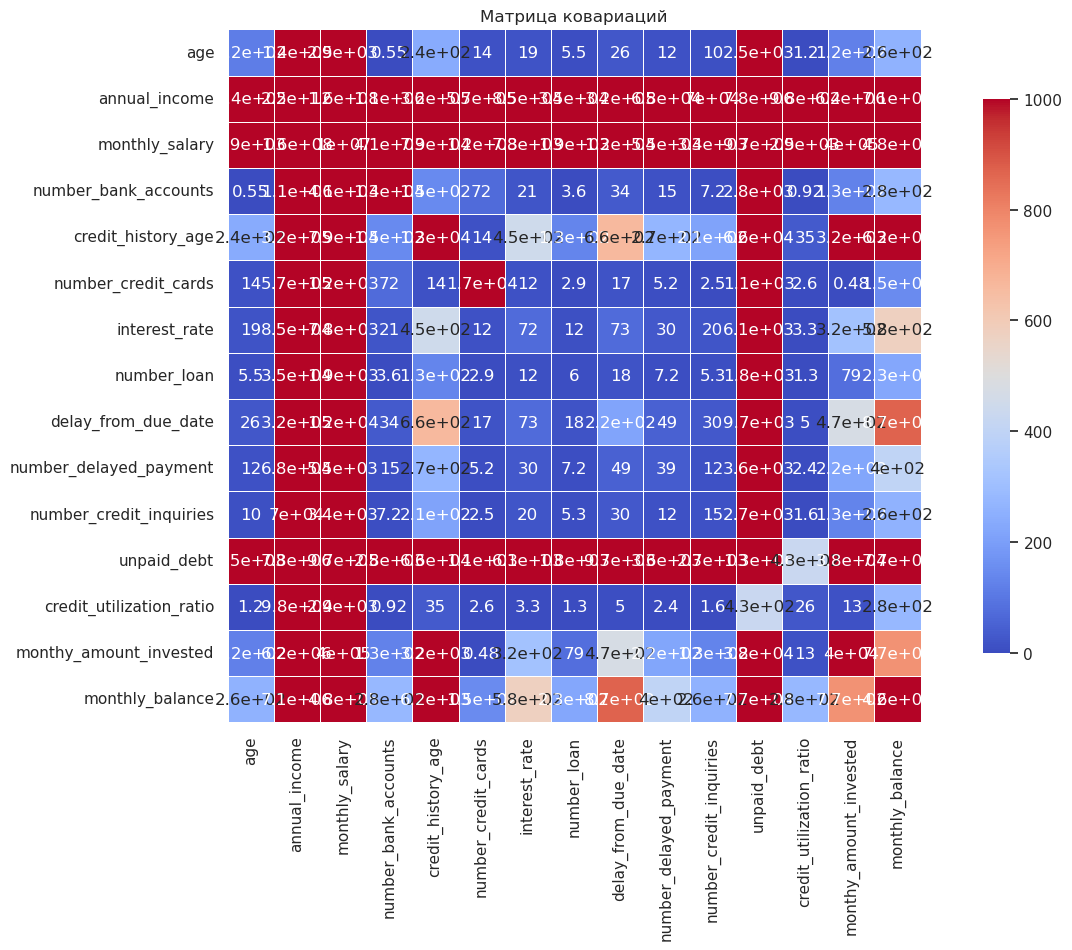

In [39]:
cov_matrix = train[real_features].cov()

# Построение тепловой карты
plt.figure(figsize=(16, 9))
sns.heatmap(np.abs(cov_matrix), annot=True, cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, linewidth=.5, vmin=0, vmax=1000)
plt.title('Матрица ковариаций')
plt.show()

**Выводы:**
* Признаки `annual_income`, `montly_salary` и `unpaid_debt` сильно коррелируют со всеми остальными.
* Есть много выбросов по целому набору признаков, а некоторые кажутся несущественными из-за почти одинаковых свечей.
* Есть много пропусков в данных, которые можно попытаться заполнить

По итогу в лучшей посылке были предприняты следующие действия:

1. Вместо скореллированных признаков `annual_income` и `montly_salary` оставим только `percent_credit`, рассчитываемый как `montly_amount_invested` / `monthly_salary`, то есть процент закредитованности. Не так важно абсолютное значение зарплаты, сколько доля, которую человек выплачивает по кредитам, потому что если она близка к 1, то его платежеспособность сомнительна

In [40]:
train['percent_credit'] = train['monthy_amount_invested'] / train['monthly_salary']
test['percent_credit'] = test['monthy_amount_invested'] / test['monthly_salary']

2. Стоит руками бинаризовать признак `min_amount_payment`, и на его основе ввести еще два: `ever_been_min_payment`, отражающий само наличие в истории этого человека минимальной выплаты, а так же `min_payment_part`, равный среднему по `min_amount_payment` (физический смысл-доля таких выплат у человека).

In [41]:
def parse_min_payment(str):
    '''Бинаризация признака min_amount_payment'''
    if pd.isna(str):
        return "nan"
    elif (str == 'Yes'):
        return 1
    else:
        return 0
    

train['min_amount_payment'] = train['min_amount_payment'].apply(parse_min_payment)
test['min_amount_payment'] = test['min_amount_payment'].apply(parse_min_payment)

train_grouped = train.groupby('client_id')
train['ever_been_min_payment'] = train_grouped['min_amount_payment'].cummax()
train['min_payment_part'] = train_grouped['min_amount_payment'].cumsum()
train['min_payment_part'] = train['min_payment_part'] / 8 #читерство, что для каждого id ровно 8 записей

test_grouped = test.groupby('client_id')
test['ever_been_min_payment'] = test_grouped['min_amount_payment'].cummax()
test['min_payment_part'] = test_grouped['min_amount_payment'].cumsum()
test['min_payment_part'] = test['min_payment_part'] / 8

3. Стоит разбить `client_behaviour` на два столбца, отдельно с тратами и платежами. Исходный столбец можно сразу смело дропнуть.

In [42]:
train[['spent_amount', 'invest_amount']] = train['client_behaviour'].str.split(', ', expand=True)
test[['spent_amount', 'invest_amount']] = test['client_behaviour'].str.split(', ', expand=True)

train.drop(columns=['client_behaviour'], inplace=True)
test.drop(columns=['client_behaviour'], inplace=True)

4. Введем суммарную задержку по всем кредитам:

In [43]:
train['sum_delay'] = train['delay_from_due_date'] * train['number_delayed_payment']
test['sum_delay'] = test['delay_from_due_date'] * test['number_delayed_payment']

Наконец, окончательно определимся, какие фичи вещественные, какие категориальные, какие мы игнорируем. То, какие мы игнорируем, было получено по итогу прошлых попыток, а именно я пытался отбрасывать фичи с 0 важностью. Также, заполним пропуски в категориальных признаках строкой `nan`

In [44]:
def fill_nans_str(str):
    if pd.isna(str):
        return "nan"
    else:
        return str
    
target = 'credit_rating'
cat_features = ['occupation', 'month', 'spent_amount', 'invest_amount']
real_features = ['age', 'annual_income', 'monthly_salary', 'number_bank_accounts', 'credit_history_age','number_credit_cards', 'interest_rate', 'number_loan', 'delay_from_due_date', 'number_delayed_payment', 'number_credit_inquiries', 'unpaid_debt', 'credit_utilization_ratio', 'monthy_amount_invested', 'monthly_balance']

train[cat_features] = test[cat_features].astype(str)
test[cat_features] = test[cat_features].astype(str)

for feature in cat_features:
    train[feature] = train[feature].apply(fill_nans_str)
    test[feature] = test[feature].apply(fill_nans_str)
    train[feature] = train[feature].str.lower()
    test[feature] = test[feature].str.lower()

bad_features = ['annual_income', 'monthy_amount_invested', 'monthly_salary', 'spent_amount']

А теперь, внимание, главная фишечка, **ИЗМЕНИМ ТАРГЕТ НА ВЕЩЕСТВЕННЫЙ**. Это мотивированно тем, что в реальной жизни кредитный рейтинг-число от 0 до ~1000, да и просто логически рейтинг-не категория, а вполне сравнимая вещественная величина. Поэтому присвоим в зависимости от категории значения 1, 2 или 3 и будем учить `CatBoostRegressor` по метрике `MSE`, после чего переведем таргет обратно

In [45]:
def code_target(str):
    '''Переход от категориального таргета к вещественному'''
    if(str == 'Хороший'):
        return 3
    elif(str == 'Обычный'):
        return 2
    else:
        return 1


train['credit_rating'] = train['credit_rating'].apply(code_target)

Наконец, подберем параметры для нашей модели. На валидации используем `StratifiedGroupKFold` (чтобы доля таргетов была одинаковой и чтобы один и тот же клиент не попал в тренировочную и валидационную выборку). Кроме того, стоит обратить внимание на `nan_mode` - режим обработки пропусков в данных.

In [46]:
param_distributions = {
    'n_estimators' : np.arange(1, 300),
    'max_depth' : range(4, 10),
    'learning_rate' : np.linspace(0.01, 0.3, 10000),
    'min_data_in_leaf' : np.arange(1, 7),
    'l2_leaf_reg' : np.linspace(0, 10, 101),
    'nan_mode' : ['Min', 'Max']
}

sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=1337)
# определяем поиск по сетке
forth_catboost = RandomizedSearchCV(
    estimator=CatBoostRegressor(cat_features=cat_features,
                                 silent=True, task_type='GPU', thread_count=-1, ignored_features=bad_features),
    param_distributions=param_distributions,
    scoring='neg_mean_squared_error',
    n_iter=300,
    n_jobs=1,
    cv=sgkf.split(train.drop(columns=['credit_rating', 'client_id']), train['credit_rating'], train['client_id']),
    verbose=10,
    error_score='raise',
    random_state=42
)

forth_catboost.fit(train.drop(columns=['credit_rating', 'client_id']), train['credit_rating'])
forth_catboost.best_score_

Fitting 4 folds for each of 300 candidates, totalling 1200 fits
[CV 1/4; 1/300] START l2_leaf_reg=8.3, learning_rate=0.143993399339934, max_depth=8, min_data_in_leaf=4, n_estimators=47, nan_mode=Min
[CV 1/4; 1/300] END l2_leaf_reg=8.3, learning_rate=0.143993399339934, max_depth=8, min_data_in_leaf=4, n_estimators=47, nan_mode=Min;, score=-0.279 total time=   0.4s
[CV 2/4; 1/300] START l2_leaf_reg=8.3, learning_rate=0.143993399339934, max_depth=8, min_data_in_leaf=4, n_estimators=47, nan_mode=Min
[CV 2/4; 1/300] END l2_leaf_reg=8.3, learning_rate=0.143993399339934, max_depth=8, min_data_in_leaf=4, n_estimators=47, nan_mode=Min;, score=-0.287 total time=   0.5s
[CV 3/4; 1/300] START l2_leaf_reg=8.3, learning_rate=0.143993399339934, max_depth=8, min_data_in_leaf=4, n_estimators=47, nan_mode=Min
[CV 3/4; 1/300] END l2_leaf_reg=8.3, learning_rate=0.143993399339934, max_depth=8, min_data_in_leaf=4, n_estimators=47, nan_mode=Min;, score=-0.276 total time=   0.5s
[CV 4/4; 1/300] START l2_leaf_

/home/roman/HW/myenv2/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


-0.2782243204782632

Посмотрим на лучшие параметры:

In [47]:
forth_catboost.best_params_

{'nan_mode': 'Max',
 'n_estimators': 288,
 'min_data_in_leaf': 6,
 'max_depth': 7,
 'learning_rate': 0.03378237823782378,
 'l2_leaf_reg': 1.3}

Обучим нашу модель с подобранными параметрами теперь на всей тренировочной выборке:

In [48]:
forth_catboost_params = {'nan_mode': 'Max',
 'n_estimators': 288,
 'min_data_in_leaf': 6,
 'max_depth': 7,
 'learning_rate': 0.03378237823782378,
 'l2_leaf_reg': 1.3}
bad_features = ['annual_income', 'monthy_amount_invested', 'monthly_salary', 'spent_amount']
forth_catboost_model = CatBoostClassifier(cat_features=cat_features, 
                                 silent=True, task_type='GPU', thread_count=-1, ignored_features=bad_features, **forth_catboost_params)
forth_catboost_model.fit(train.drop(columns=['credit_rating', 'client_id']), train['credit_rating'])

Сделаем предсказания и переведем их обратно в категориальные по самому тупому правилу.

In [49]:
def decode_target(num):
    if(num < 1.5):
        return "Плохой"
    elif(num < 2.5):
        return "Обычный"
    else:
        return "Хороший"

pred = forth_catboost_model.predict(test.drop(columns='client_id').values)
pred = pd.DataFrame(pred, columns=['credit_rating'])
pred['credit_rating'] = pred['credit_rating'].apply(decode_target)
pred.to_csv("predictions_check.csv", sep=",", index_label='index')

Ради интереса можно посмотреть на важность признаков:

In [50]:
for value, name in sorted(
    zip(forth_catboost_model.get_feature_importance(fstr_type='FeatureImportance'), 
        train.drop(columns=['credit_rating', 'client_id'])), 
    reverse=True
):
    print('{}\t{:.2f}'.format(name, value))

unpaid_debt	17.18
interest_rate	14.05
number_credit_cards	11.35
delay_from_due_date	9.69
min_payment_part	8.23
ever_been_min_payment	6.81
number_bank_accounts	5.92
credit_history_age	5.10
number_credit_inquiries	4.48
age	3.43
number_delayed_payment	3.30
number_loan	2.31
occupation	2.14
monthly_balance	1.63
sum_delay	1.58
min_amount_payment	1.41
percent_credit	1.00
credit_utilization_ratio	0.37
invest_amount	0.01
spent_amount	0.00
monthy_amount_invested	0.00
monthly_salary	0.00
month	0.00
annual_income	0.00


**Некоторые интересные идеи:**

Данные идеи порой приводили к некоторым улучшениям, но конкретно с моей лучше посылкой не прокатили
1. Введение параметра `num_rejects` как разность `credit_inquiries` и `number_loan`, физический смысл-количество отказов по кредитам. Признак значимый, но коррелирует с двумя исходными, поэтому его пришлось выкинуть при переходе к вещественному таргету, но с категориальным он хорошо помогал
2. Я пытался по-разному заполнять данные, например `occupation` и `age` по самому частому значению у того же клиента, вещественные признаки по среднему/медиане по тому же клиенту, но в итоге все это приводило к катастрофическим ухудшениям. 

**Возможные улучшения:**
1. Подобрать пороги, по которым таргеты переводятся обратно в категориальные (я пытался, но качество просело из-за малого количества итераций самописного случайного поиска и поджимающего времени, переход от посылки 4.2 к 4.3).
2. Не придумал ничего с `monthly_balance` и уже после конца соревнования понял, что остаток на счетах у человека должен сильно влиять и можно было повводить новые признаки, связанные с ним.